# Bile Duct Classification

From the previous work we developed a segmentation pipeline that returns a labeled segmentation image for Sox9+ cells, holes corresponding to vessels, debris, fibrotic structures as mesenchyma and livers. Now, we will classify the segmented Sox9+ cels according to their morphology to distinguish between five different classes:

![Bile duct classes](bile_duct_classes.png "Bile duct classes")

1. Well formed
2. Functional
3. Opened Circle
4. Cluster
5. Single cells

In [1]:
from pathlib import Path

import apoc
import napari
import pyclesperanto_prototype as cle
from skimage.io import imread

from gulliver.classifier import predict_bile_duct_classes_from_table
from gulliver.io import get_image
from gulliver.segmenter import find_structures, relabel_image
from gulliver.quantify import get_properties, find_distances

cle.select_device("RTX")
print(cle.get_device().name)

c:\Users\agucor\Anaconda3\envs\bile_duct_clf\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


NVIDIA GeForce RTX 3060 Laptop GPU


In [2]:
DATA_DIR = Path("../data/143 E8.czi")

image = get_image(DATA_DIR, 1)

In [3]:
n = 7
segmentations = find_structures(
    image["Sox9"]["image"], chunk_shape=(n * 1024, n * 1024)
)

This way we have the whole image and the labels for Sox9 cells, as well as debris and holes. Here we can paint a couple structures with the class labels stated at the beginning of the document. There is no need to be strict eith painting every pixel or pixels inside the area, just paint!

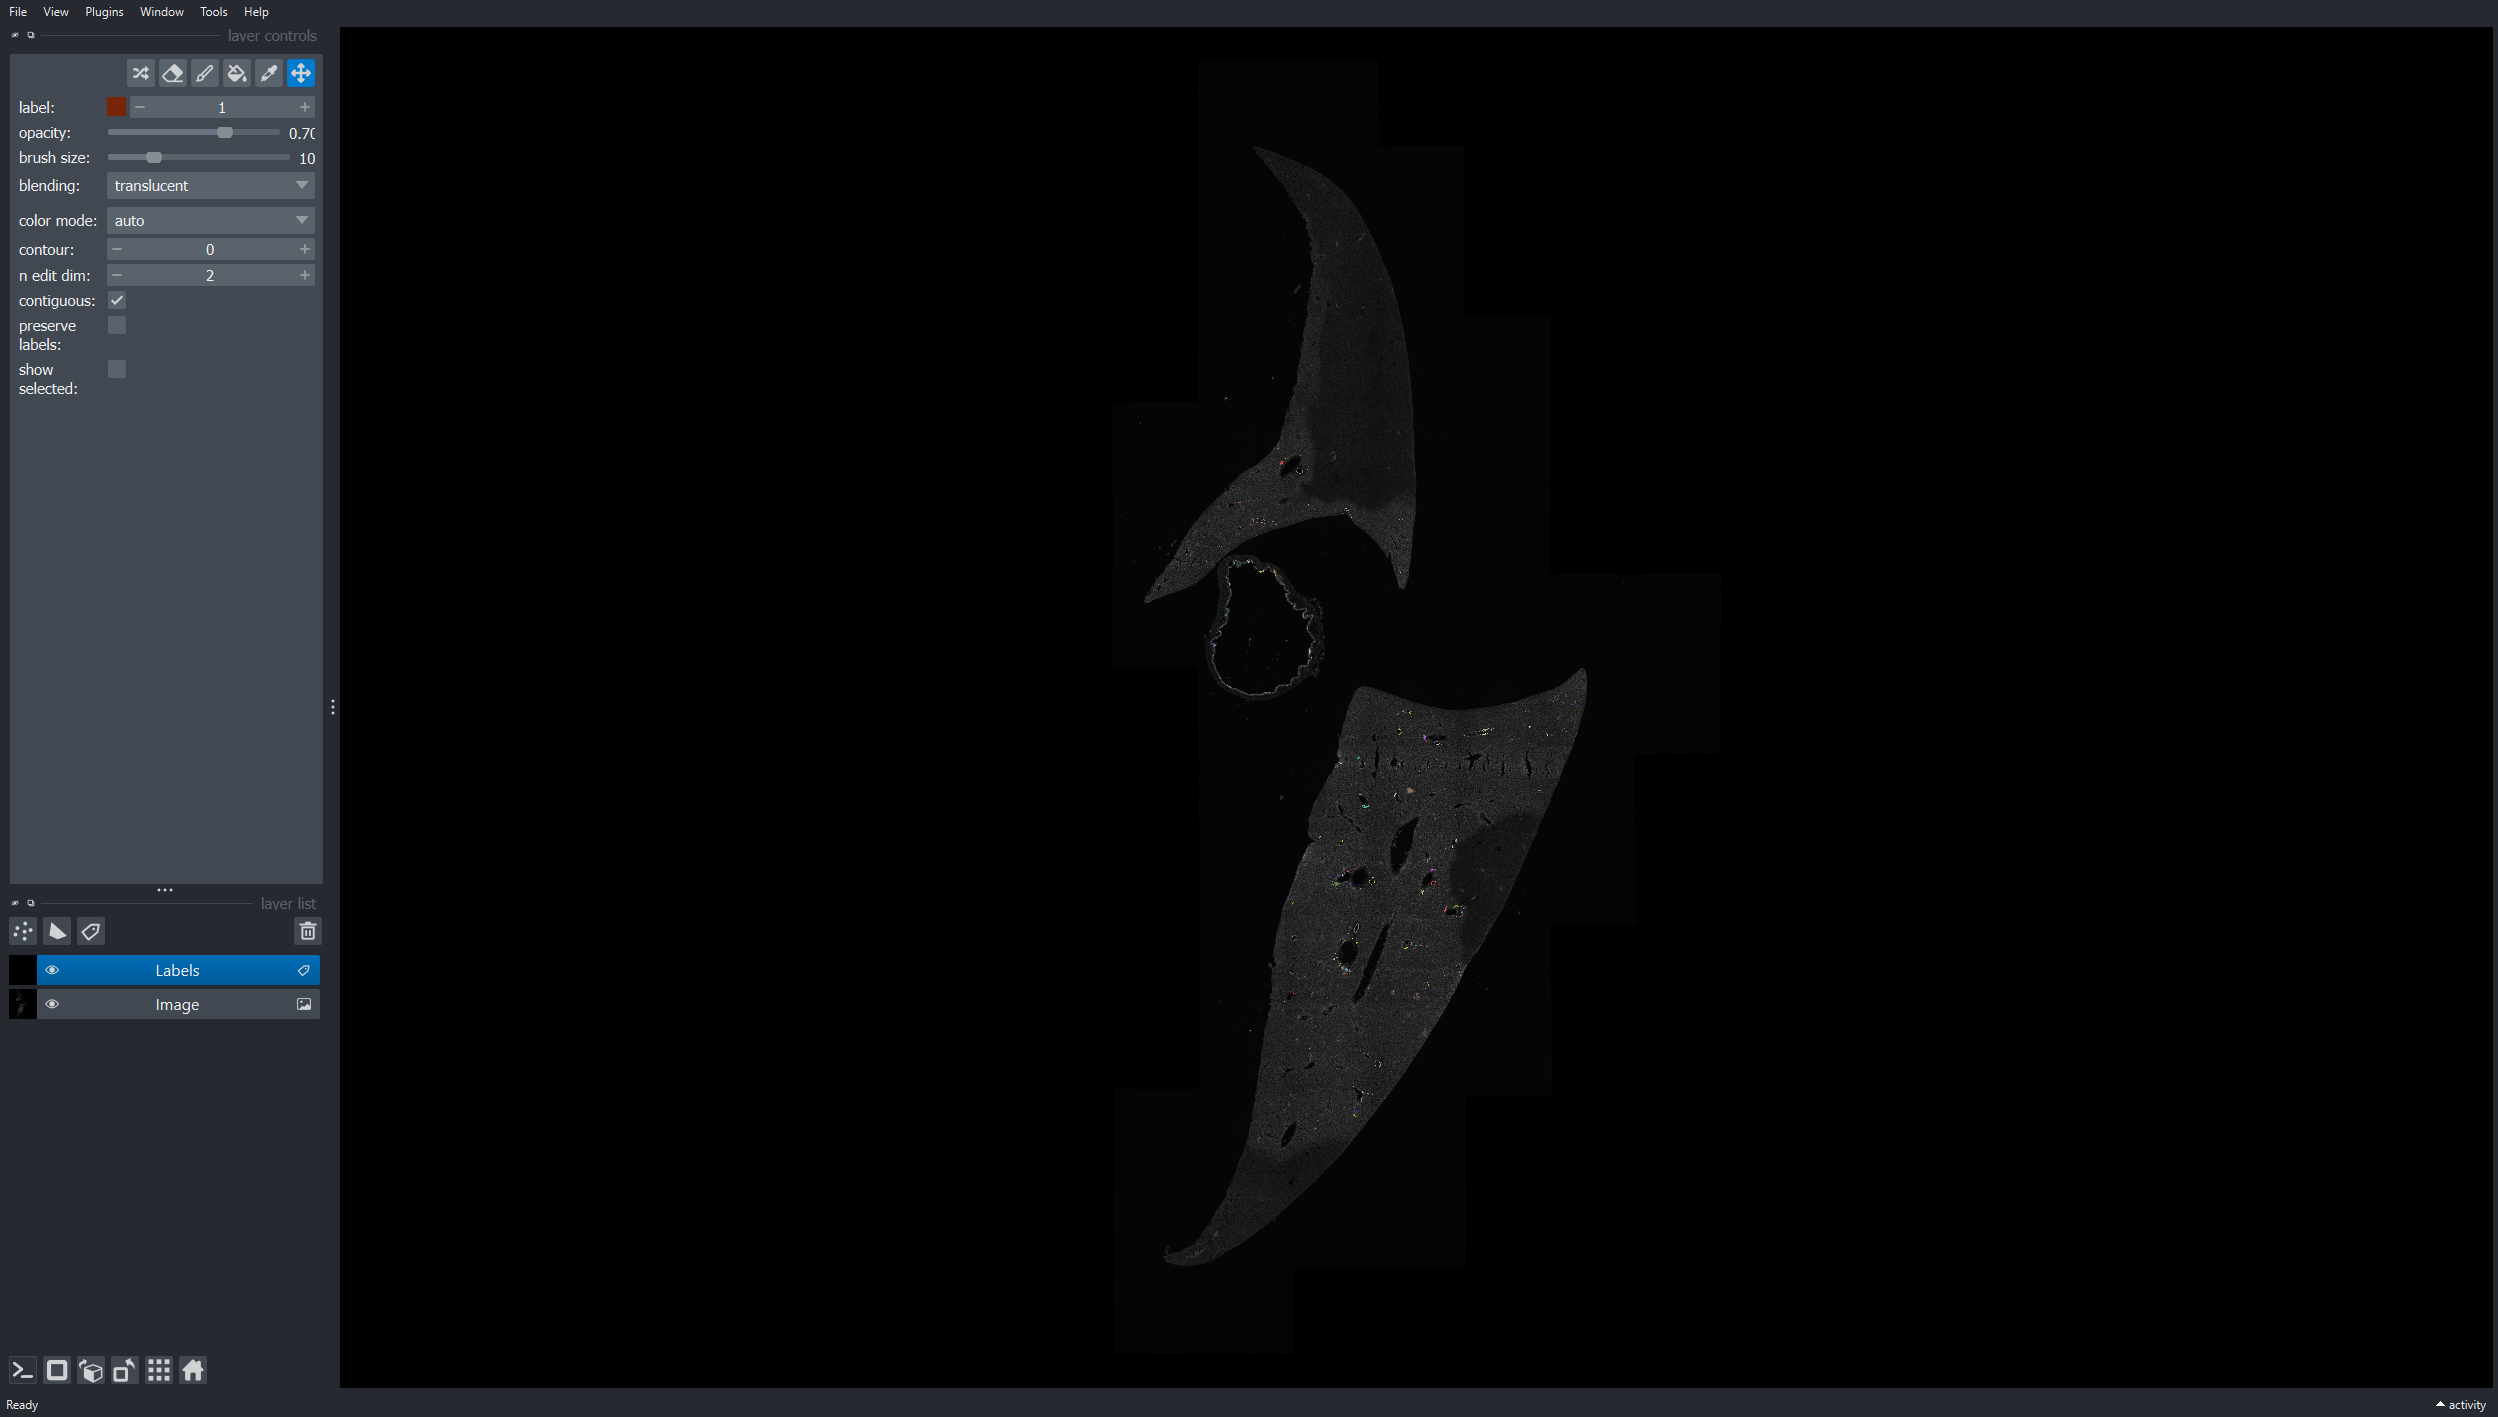

In [4]:
viewer = napari.Viewer()

viewer.add_image(image["Sox9"]["image"], contrast_limits=(0, 2**13))
viewer.add_labels(segmentations["sox9_positive"]["labels"][:])
napari.utils.nbscreenshot(viewer)

In [5]:
for_training = imread("../train/sox9_class_for_training.tiff")

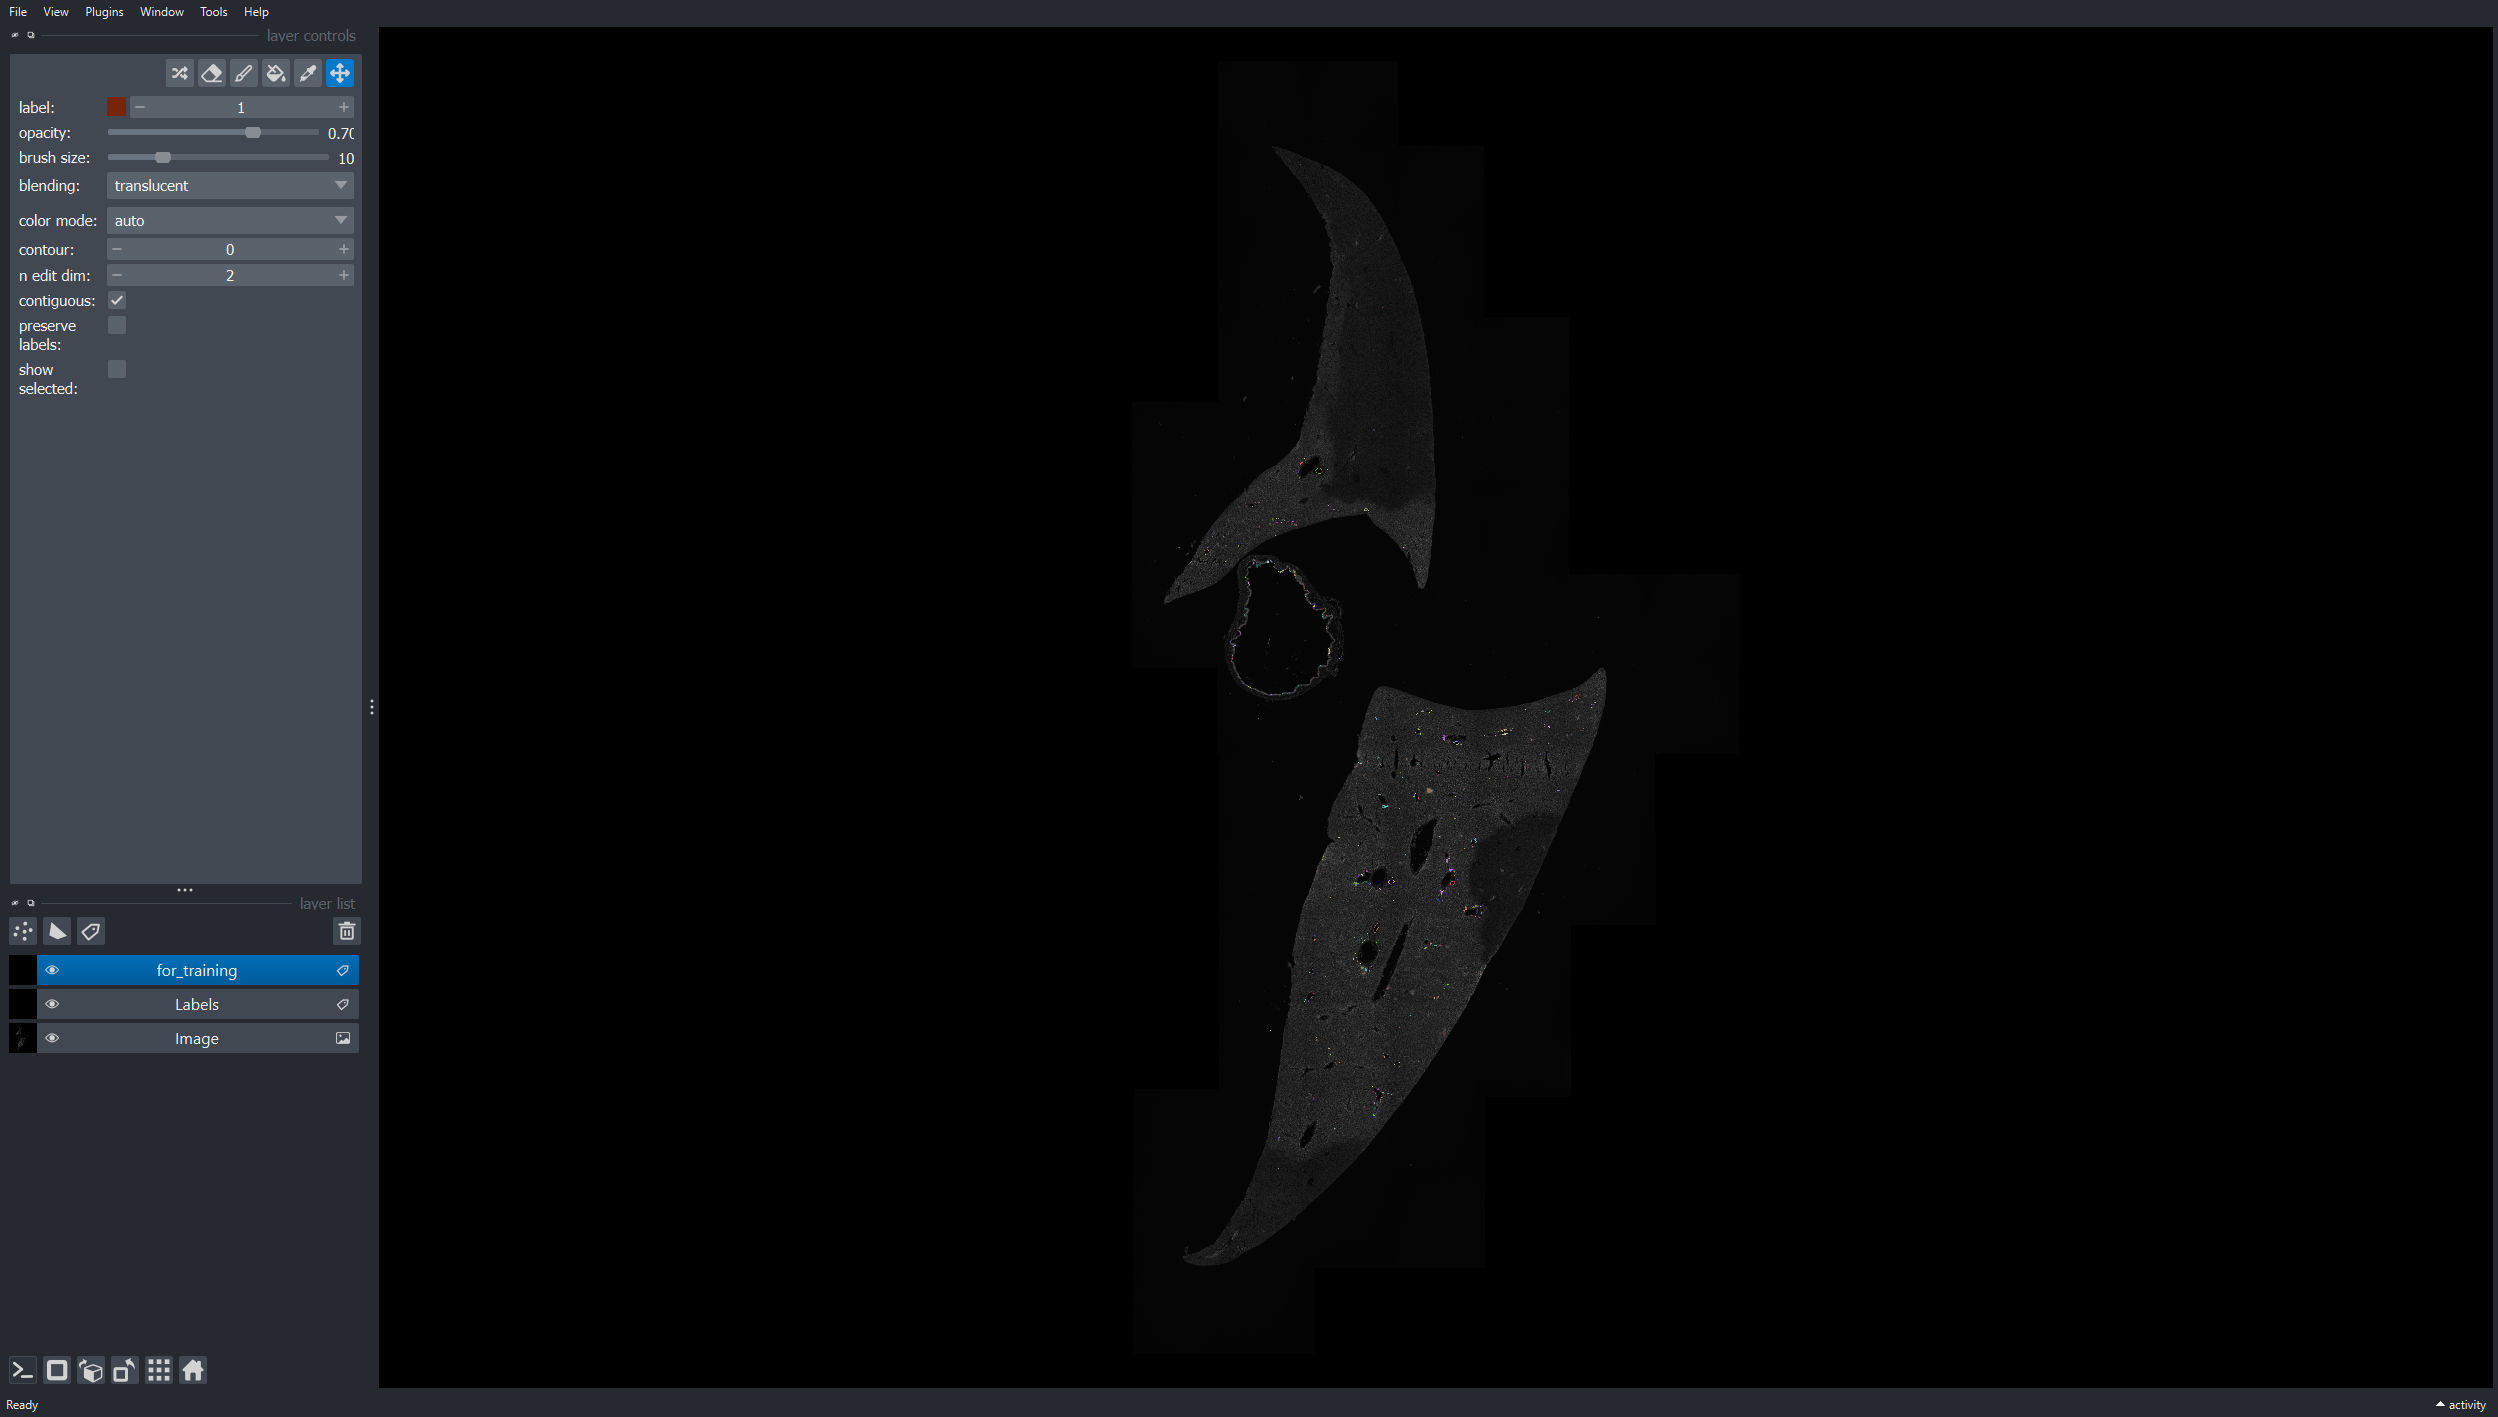

In [6]:
viewer = napari.Viewer()

viewer.add_image(image["Sox9"]["image"], contrast_limits=(0, 2**13))
viewer.add_labels(segmentations["sox9_positive"]["labels"][:])
viewer.add_labels(for_training)
napari.utils.nbscreenshot(viewer)

After setting the classes for some of the Sox9+ cells, we can train a classifier

In [7]:
properties = get_properties(
    segmentations["sox9_positive"]["labels"], for_training
)

In [8]:
properties

,area,area_convex,area_filled,axis_major_length,axis_minor_length,bbox-0,bbox-1,bbox-2,bbox-3,eccentricity,...,label,moments_hu-0,moments_hu-1,moments_hu-2,moments_hu-3,moments_hu-4,moments_hu-5,moments_hu-6,perimeter,solidity
0,554.0,587.0,554.0,37.143673,19.401244,5276,5363,5304,5396,0.852744,...,1,0.198112,0.012810,0.000277,5.755615e-05,6.953323e-09,5.494998e-06,-2.098793e-09,97.497475,0.943782
1,88.0,96.0,88.0,10.634421,10.556421,6132,4296,6143,4307,0.120895,...,2,0.159467,0.000001,0.000042,6.091112e-08,-9.770746e-14,-7.150536e-11,-5.616690e-28,32.970563,0.916667
2,288.0,324.0,288.0,30.034628,12.989765,7220,2442,7245,2464,0.901637,...,3,0.232381,0.025327,0.001711,5.216530e-04,4.859759e-07,7.995148e-05,8.217396e-08,73.012193,0.888889
3,194.0,208.0,194.0,21.053550,11.842674,7900,5182,7912,5203,0.826796,...,4,0.187984,0.009529,0.000174,1.860473e-05,9.679934e-10,1.516796e-06,4.313618e-10,53.798990,0.932692
4,116.0,125.0,116.0,15.601564,9.650750,8277,3572,8291,3585,0.785725,...,5,0.181329,0.006555,0.000340,2.177095e-05,1.357810e-09,1.137852e-06,-1.288810e-09,40.627417,0.928000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,86.0,95.0,86.0,11.080183,9.890954,22775,4365,22785,4377,0.450710,...,686,0.160321,0.000329,0.000010,1.143235e-08,1.289961e-15,-9.476041e-11,-3.599329e-15,32.970563,0.905263
686,841.0,971.0,841.0,34.869728,34.501026,22889,4336,22926,4372,0.145036,...,687,0.178821,0.000004,0.001867,3.364151e-06,2.295987e-10,-6.389741e-09,-1.355925e-10,125.882251,0.866117
687,64.0,72.0,64.0,9.739050,8.375614,23013,4371,23022,4381,0.510289,...,688,0.161133,0.000582,0.000000,0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00,28.142136,0.888889
688,608.0,966.0,608.0,49.676968,27.358964,23099,3132,23142,3171,0.834679,...,689,0.330624,0.031236,0.032149,6.022830e-03,8.339947e-05,1.022906e-03,-8.263793e-06,142.124892,0.629400


We should add columns measuring the distance to the closest lumenized structures and mesenchyma (often detected as not well stained).

In [9]:
holes_distance_table = find_distances(
    segmentations["sox9_positive"]["labels"],
    segmentations["holes"]["labels"][:] > 0,
    suffix="holes",
)

In [10]:
not_well_stained_distance_table = find_distances(
    segmentations["sox9_positive"]["labels"],
    segmentations["not_well_stained"]["labels"][:] > 0,
    suffix="not_well_stained",
)

In [11]:
properties.set_index("label", verify_integrity=True, inplace=True)
properties = properties.join(holes_distance_table.set_index("label"))
properties = properties.join(not_well_stained_distance_table.set_index("label"))

In [12]:
properties

,area,area_convex,area_filled,axis_major_length,axis_minor_length,bbox-0,bbox-1,bbox-2,bbox-3,eccentricity,...,moments_hu-5,moments_hu-6,perimeter,solidity,holes_distance_max,holes_distance_min,holes_distance_mean,not_well_stained_distance_max,not_well_stained_distance_min,not_well_stained_distance_mean
label,,,,,,,,,,,,,,,,,,,,,
1,554.0,587.0,554.0,37.143673,19.401244,5276,5363,5304,5396,0.852744,...,5.494998e-06,-2.098793e-09,97.497475,0.943782,32.557641,8.544004,19.942203,19.924859,8.246211,13.835633
2,88.0,96.0,88.0,10.634421,10.556421,6132,4296,6143,4307,0.120895,...,-7.150536e-11,-5.616690e-28,32.970563,0.916667,37.656341,27.459060,32.883253,33.734256,23.537205,28.967629
3,288.0,324.0,288.0,30.034628,12.989765,7220,2442,7245,2464,0.901637,...,7.995148e-05,8.217396e-08,73.012193,0.888889,16.031220,2.828427,8.080693,20.615528,7.280110,14.064850
4,194.0,208.0,194.0,21.053550,11.842674,7900,5182,7912,5203,0.826796,...,1.516796e-06,4.313618e-10,53.798990,0.932692,40.804412,25.298221,33.250253,18.867962,9.219544,13.950172
5,116.0,125.0,116.0,15.601564,9.650750,8277,3572,8291,3585,0.785725,...,1.137852e-06,-1.288810e-09,40.627417,0.928000,73.355300,63.953108,68.546146,65.000000,55.461698,59.903027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686,86.0,95.0,86.0,11.080183,9.890954,22775,4365,22785,4377,0.450710,...,-9.476041e-11,-3.599329e-15,32.970563,0.905263,22.203603,12.529964,17.483830,35.468296,25.000000,30.154753
687,841.0,971.0,841.0,34.869728,34.501026,22889,4336,22926,4372,0.145036,...,-6.389741e-09,-1.355925e-10,125.882251,0.866117,68.600292,32.526912,49.570457,139.588681,100.647901,120.628930
688,64.0,72.0,64.0,9.739050,8.375614,23013,4371,23022,4381,0.510289,...,-0.000000e+00,0.000000e+00,28.142136,0.888889,36.055513,27.073973,31.640124,126.142776,118.105885,122.102980


Now that we have a table with all the properties that might be useful for classification, we can select the ones we already classified and use them for training.

In [13]:
training_table = properties.query("intensity_max > 0")

In [14]:
training_labels = training_table.index
ground_truth = training_table["intensity_max"].astype(int)

We will make a Table Row Classifier from APOC with 100 trees and a depth of 3.

In [15]:
cl_filename = "Sox9ObjectClassifier.model.cl"
num_trees = 100
max_depth = 3

apoc.erase_classifier(cl_filename)
classifier = apoc.TableRowClassifier(
    cl_filename, num_ensembles=num_trees, max_depth=max_depth
)
classifier.train(training_table.drop(columns=["intensity_max"]), ground_truth)

The next function will load the original classifier saved in the package folder.

In [16]:
prediction = predict_bile_duct_classes_from_table(
    properties.drop(columns=["intensity_max"])
)

Once we have the prediction, we can add it to the table and we can relabel the figure to have the classes shown in the image and assess the classifier.

In [17]:
predicted_image = relabel_image(
    segmentations["sox9_positive"]["labels"][:], prediction.tolist()
)

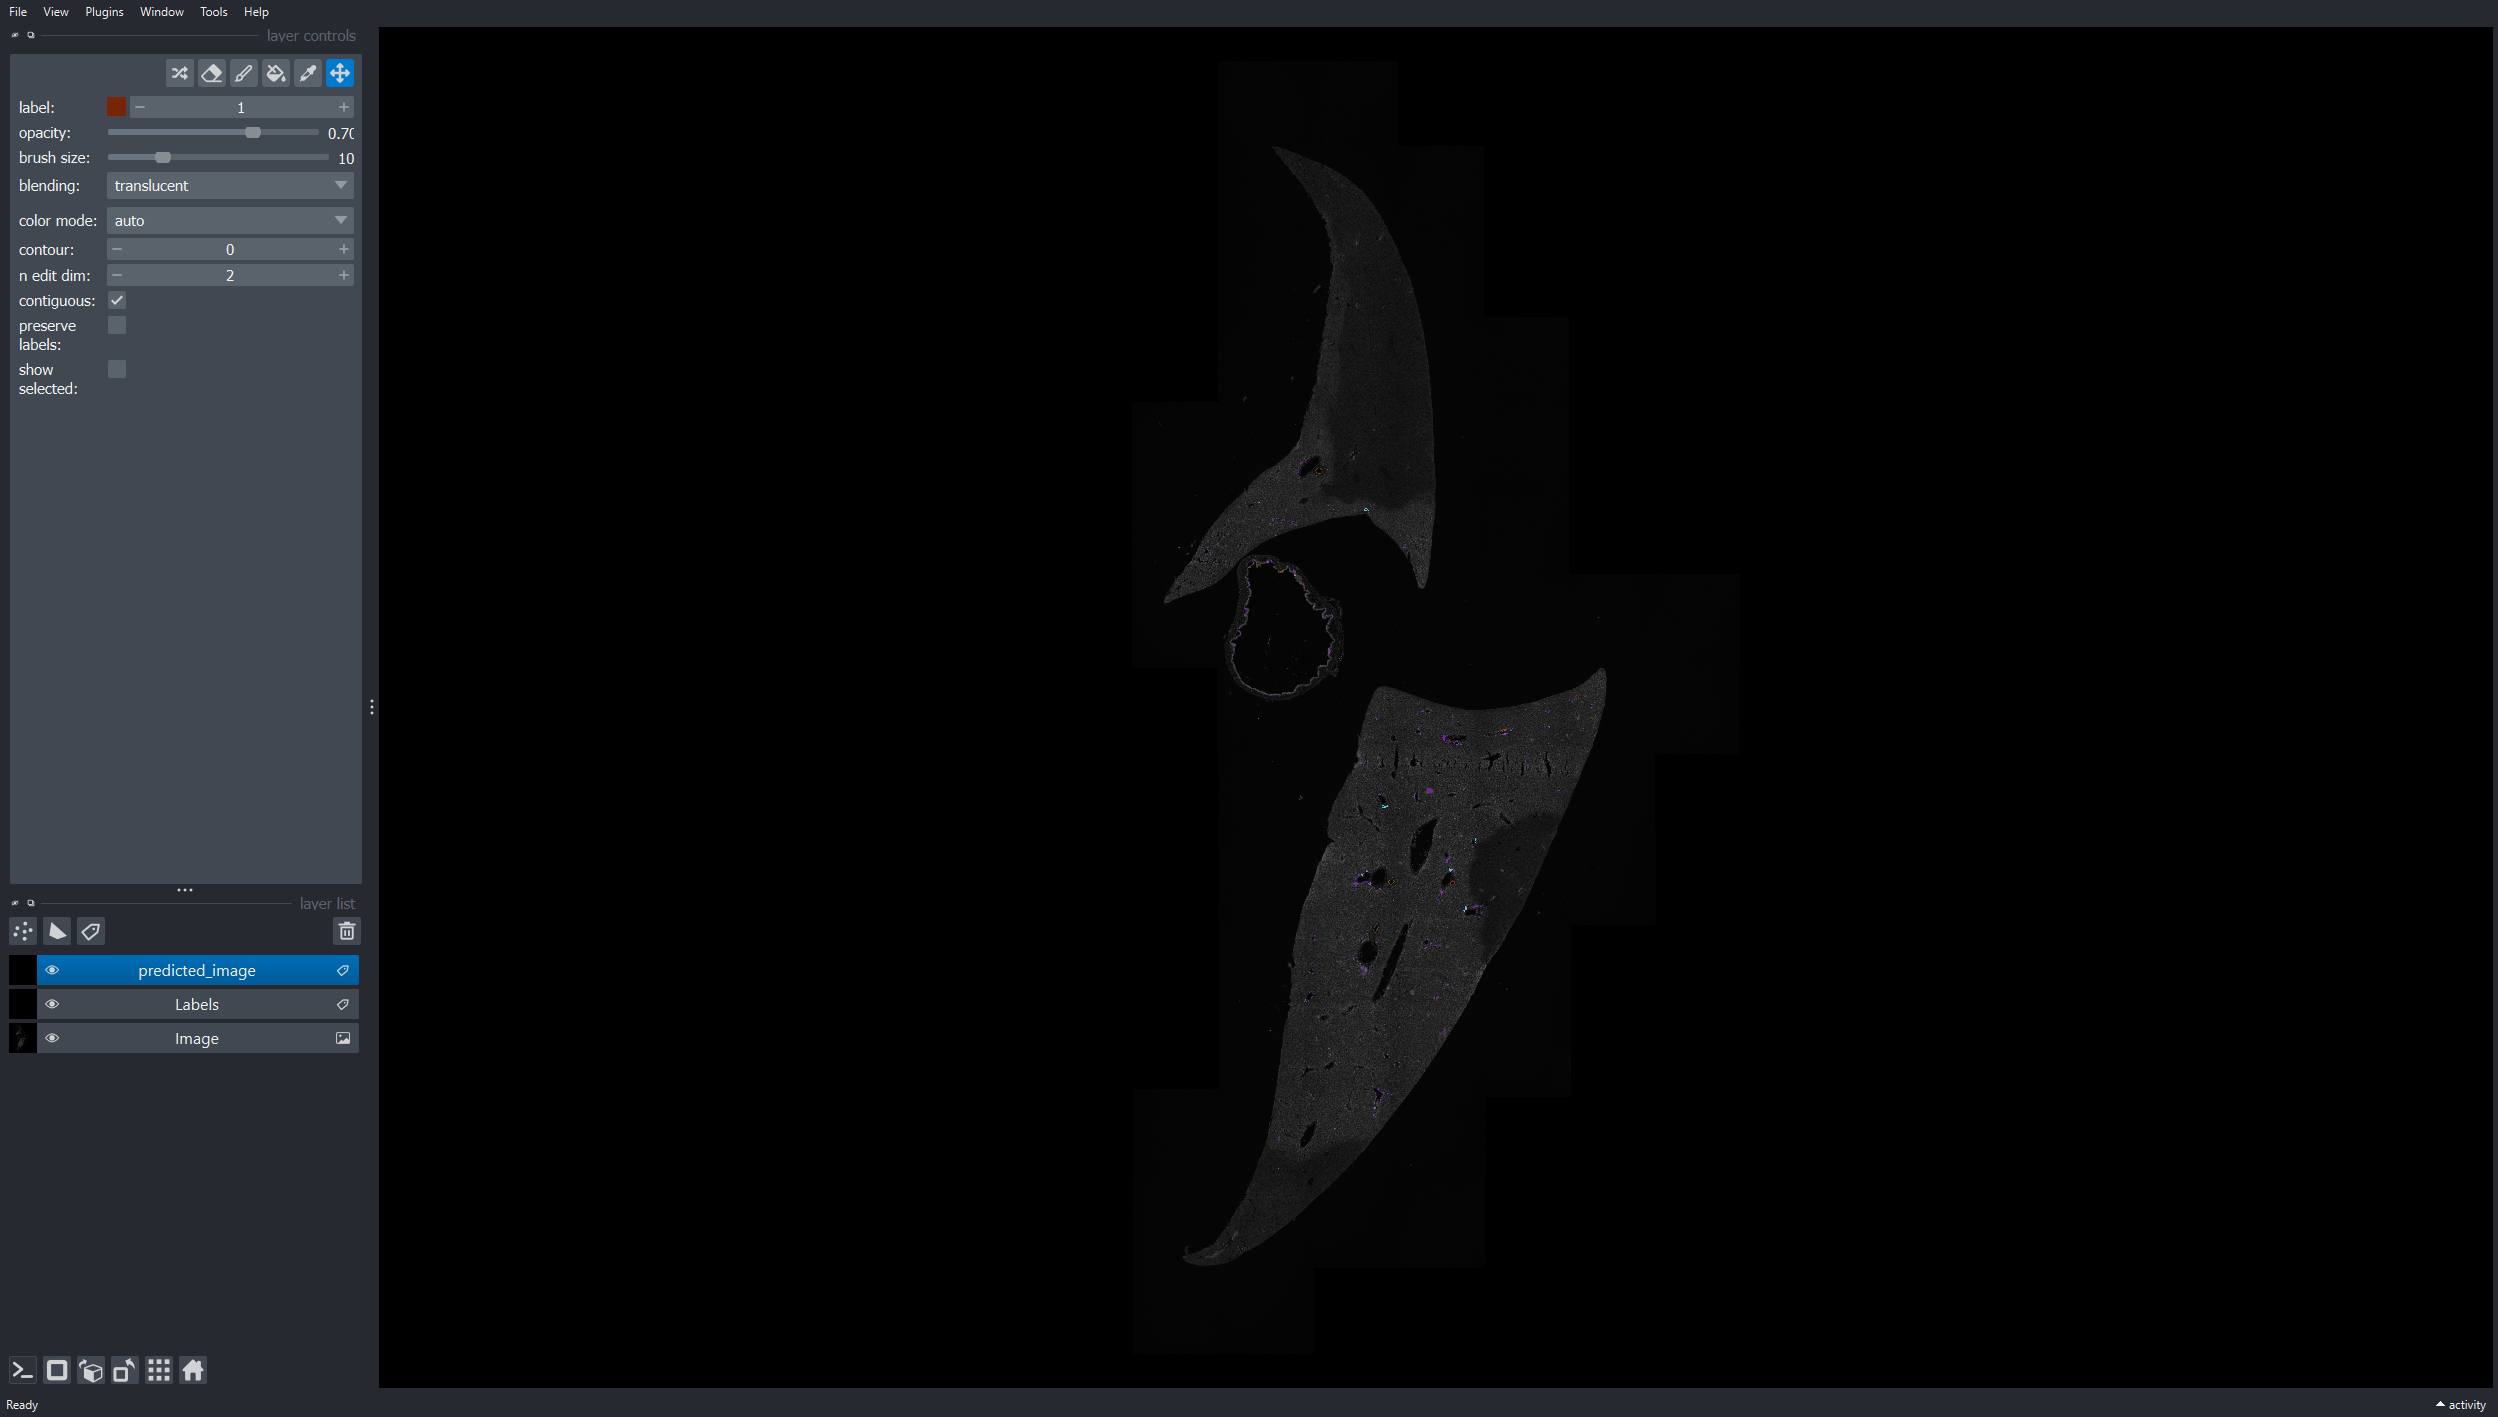

In [18]:
viewer = napari.Viewer()

viewer.add_image(image["Sox9"]["image"], contrast_limits=(0, 2**13))
viewer.add_labels(segmentations["sox9_positive"]["labels"][:])
viewer.add_labels(predicted_image)
napari.utils.nbscreenshot(viewer)